In [1]:
suppressPackageStartupMessages({
    library(VariantAnnotation)
    library(tidyverse)
})

### Nea. ancestry trajectories for different genomic regions (simulated individually)

Shown is the case of additivity ($h = 0.5$). Also mutation rate $=1e-8$ per bp per generation. This is slightly higher than what Kelley simulated ($7e-9$, roughly the mutation rate of non-synonymous mutations).

Clearly the larger proportion of deleterious sequence, the higher the impact of the Neanderthal genetic load.

Kelly simulated ~70Mb of exonic sequence and found that one needs ~10% admixture rate so that ~2-3% of Nea. ancestry survives over time. We find evidence of deleterious protein coding sequence, but also UTRs, promoter sequence and also a lot of "unidentified" non-coding sequence.

In total, our logistic regression analysis and analysis of distributions of Nea. ancestry shows that there is at least 200Mb sequence that hs been affected by selection against Nea. ancestry.

If all of that sequence behaves additively or near-dominantly, no Neanderthal ancestry would survive.

Maybe this is another evidence for recessivity of some of those regions? Protein coding + TF binding sequence? This would make different regions "compete" - recessive sequence would be prefered from Neanderthals, additive/dominant sequence would be selected against.

In [2]:
df_h <- lapply(c("exon", "promoter", "protein_coding", "tf_binding_site", "utr3"), function(r) {
lapply("0.5", function(h) {
    files <- list.files(path="../data/simulations/", pattern=paste0(r, "_h_", h, "_rep_.*trajectory.*"), full.names=TRUE)
    lapply(files, function(f) {
        suppressMessages(read_tsv(f) %>% mutate(rep=f, h=paste("dominance =", h), reg=r))
    }) %>% bind_rows
}) %>%
    bind_rows %>% 
    group_by(h, gen, reg) %>% summarise(nea_mean=mean(mean), nea_sd=mean(sd)) %>%
    ungroup
}) %>% bind_rows

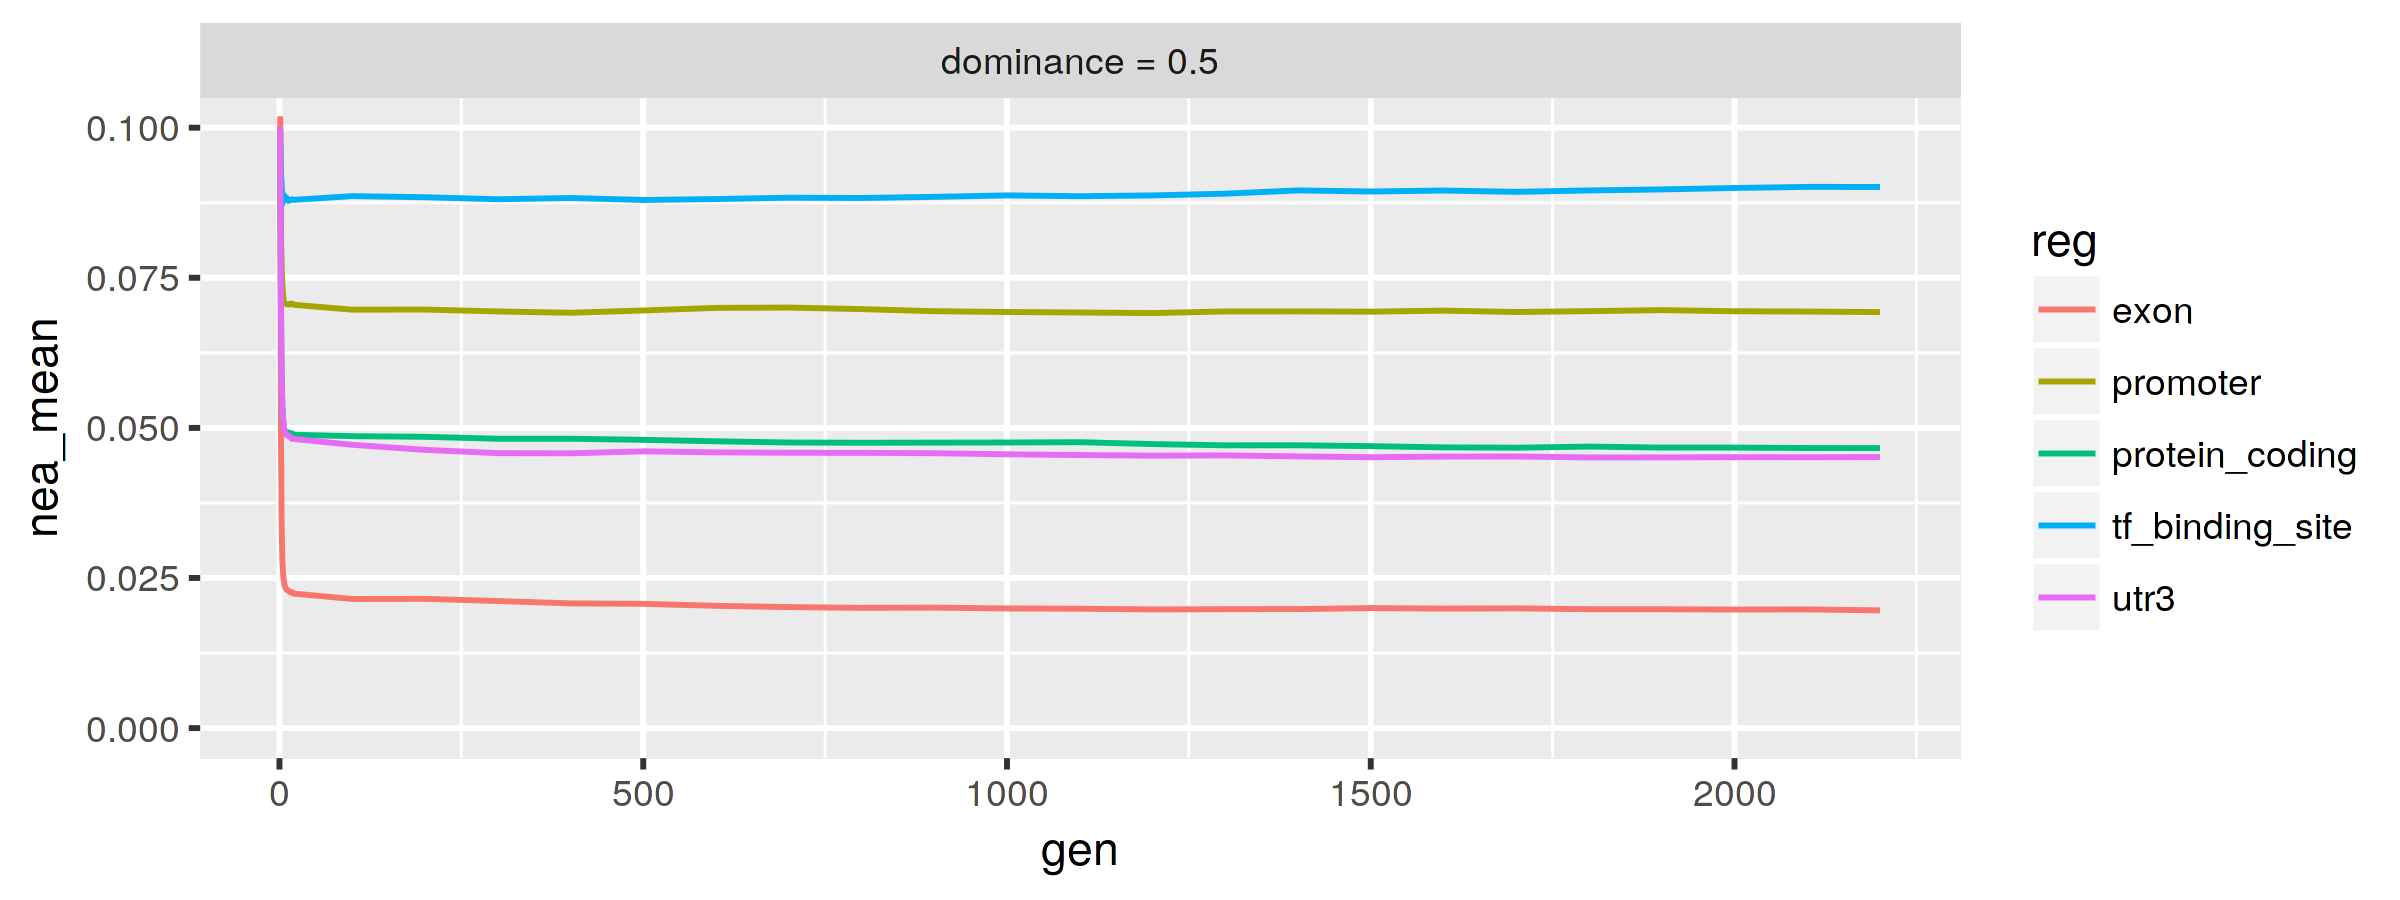

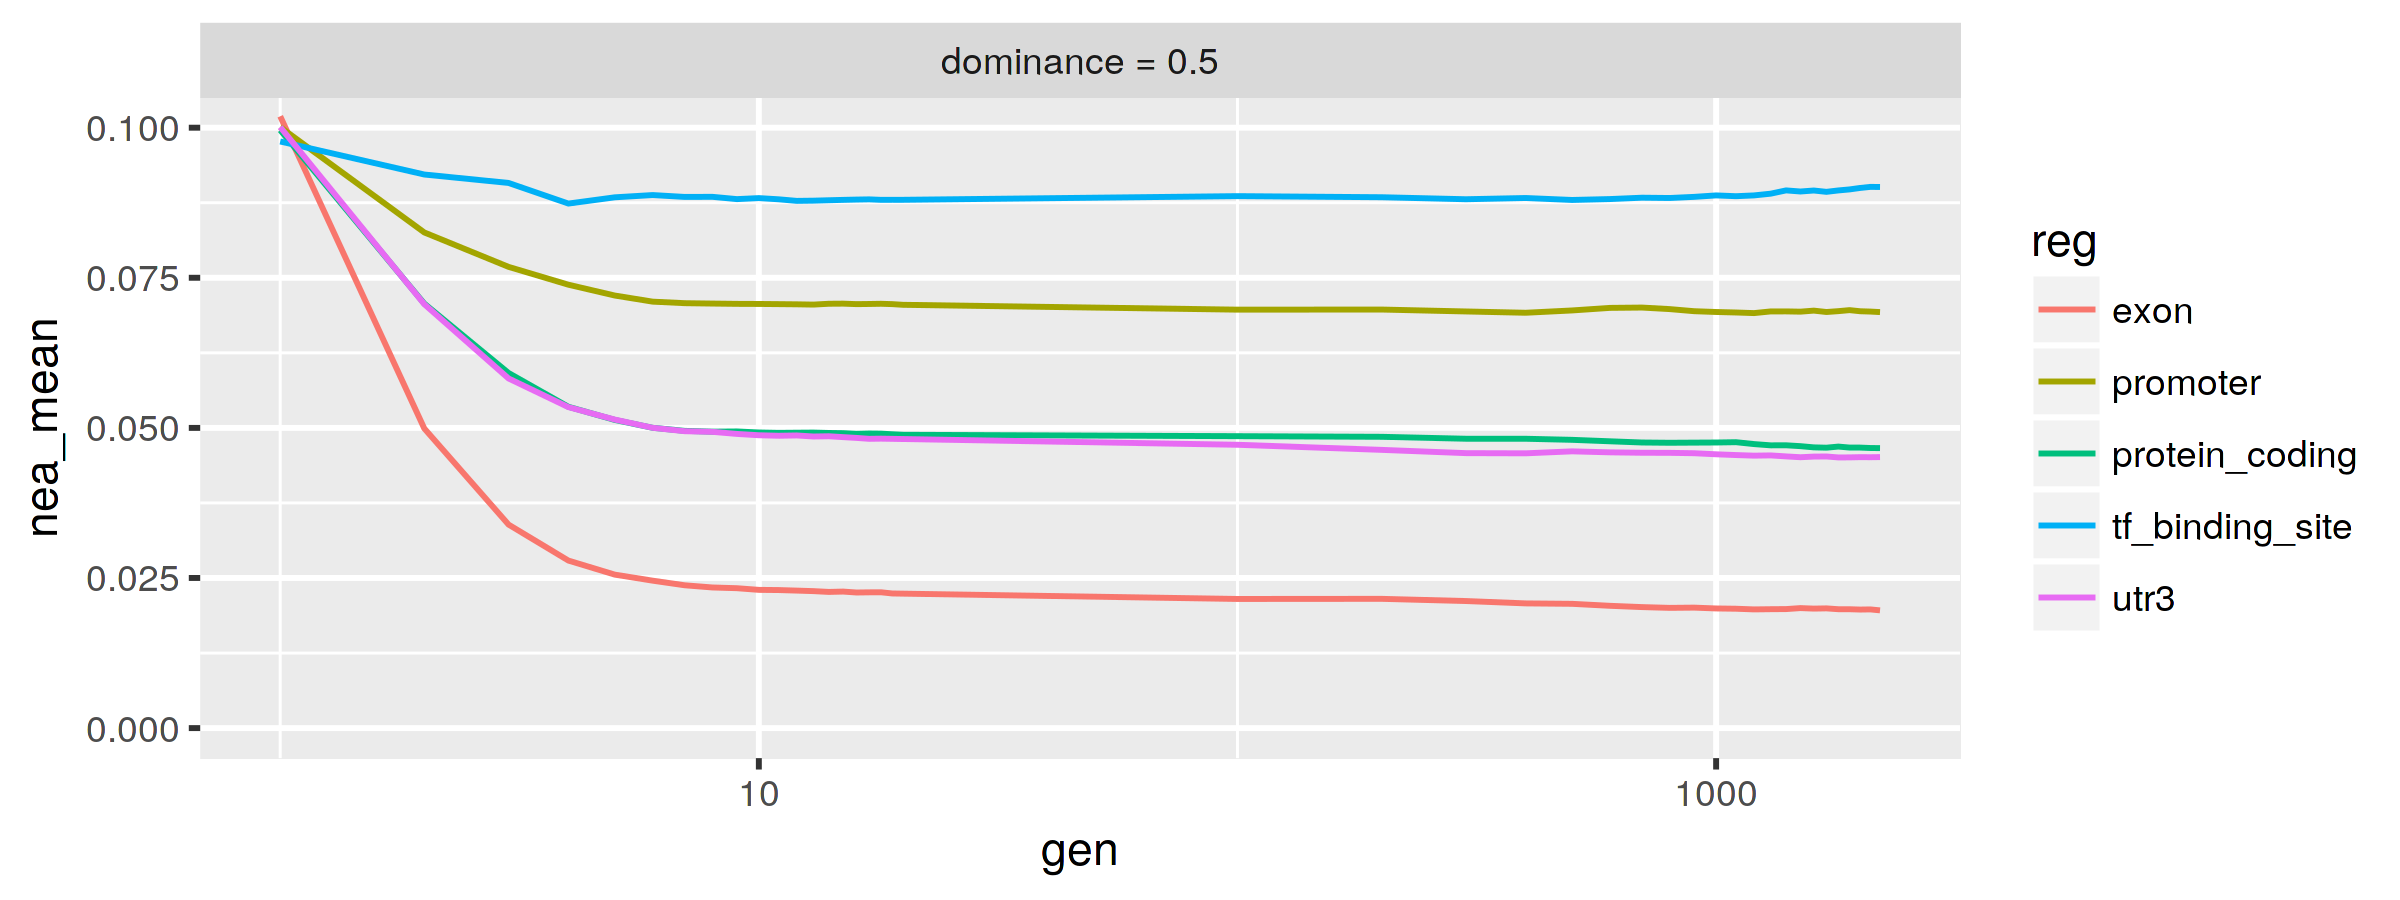

In [3]:
options(repr.plot.width=8, repr.plot.height=3, repr.plot.res=300)

ggplot(df_h, aes(gen, nea_mean)) + geom_line(aes(color=reg)) + facet_grid(. ~ h) + coord_cartesian(y=c(0, 0.1))
ggplot(df_h, aes(gen, nea_mean)) + geom_line(aes(color=reg)) + facet_grid(. ~ h) + coord_cartesian(y=c(0, 0.1)) + scale_x_log10()

## Working with the simulated VCF data

In [2]:
setwd("/mnt/scratch/mp/nea-over-time")

This script contains functions for processing and transforming VCF simulated in SLiM:

In [51]:
source("code/process_slim_vcf.R")

VCFs generated from a simulation of each genomic region dumped at the end of each simulation (generation 2200).

The VCFs contains all mutations in the simulation - deleterious (MT=0 in the INFO field) and neutral markers (MT=1 in the info field).

In [50]:
list.files("data/simulations/", "*.vcf.gz")

[1] "exon_h_0.5_rep_1_gen_2200.vcf.gz"           
[2] "promoter_h_0.5_rep_1_gen_2200.vcf.gz"       
[3] "protein_coding_h_0.5_rep_1_gen_2200.vcf.gz" 
[4] "tf_binding_site_h_0.5_rep_1_gen_2200.vcf.gz"
[5] "utr3_h_0.5_rep_1_gen_2200.vcf.gz"

In [5]:
vcf <- read_vcf("data/simulations/exon_h_0.5_rep_1_gen_2200.vcf.gz")

Load the simulated neutral markers (MT=1), calculate their frequencies and transform their coordinates from the SLiM 0-based system into their original genomic positions:

In [52]:
markers <- get_markers(vcf, "data/slim_coords/exon_all_sites.bed")

Joining, by = c("chrom", "pos")


ERROR: Error in mutate_impl(.data, dots): Evaluation error: unused argument (levels = paste0("chr", 1:22)).


In [53]:
head(markers)

chrom,pos,freq
chr1,2319599,0.135
chr1,2343936,0.120
chr1,2358871,0.030
chr1,2369679,0.285
chr1,2725162,0.250
chr1,2749331,0.165


In [54]:
options(repr.plot.width=12, repr.plot.height=15)

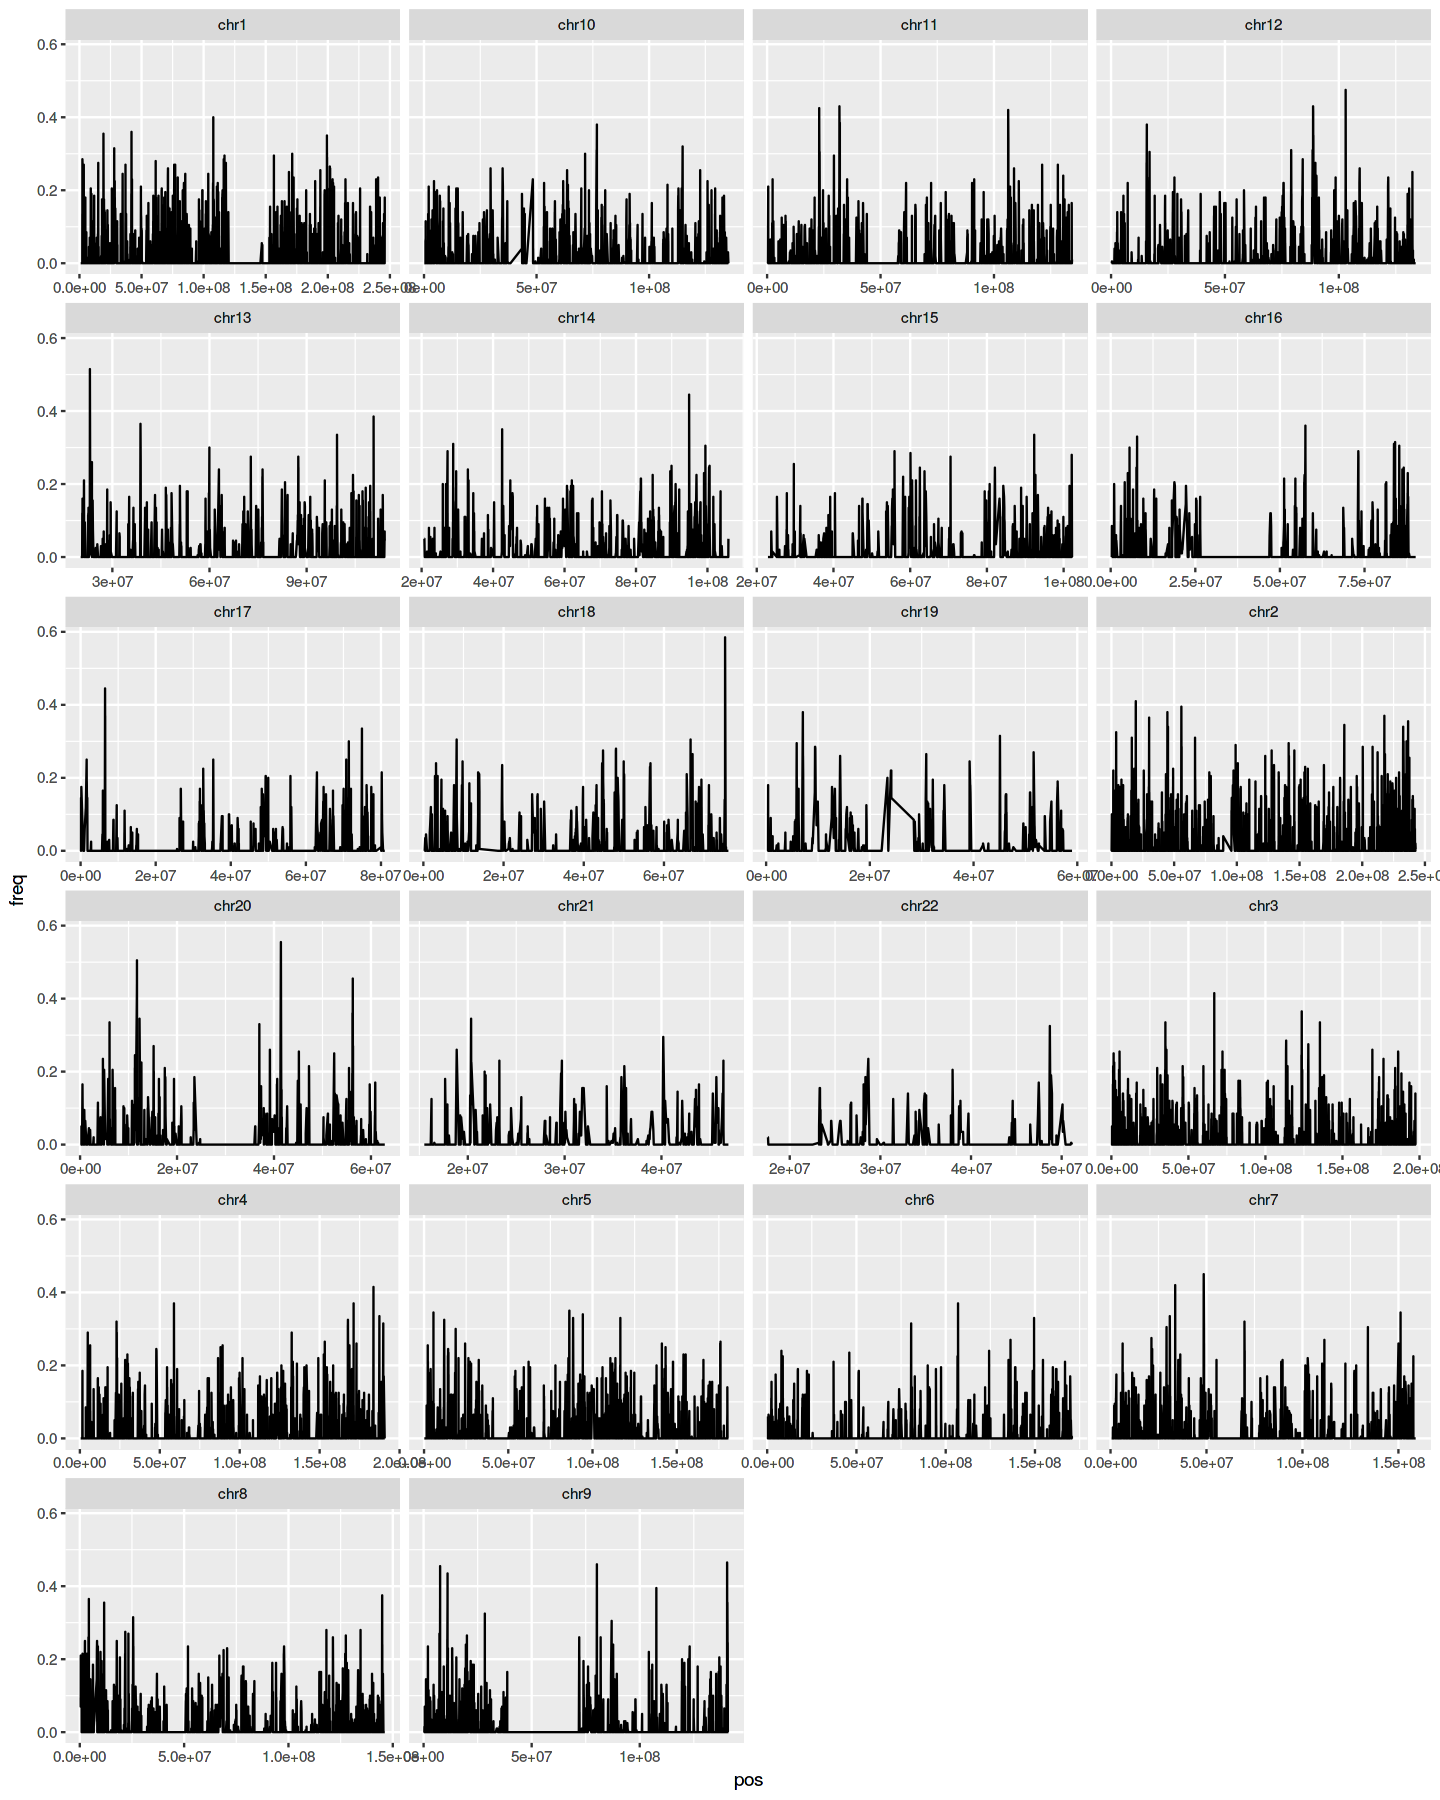

In [55]:
ggplot(markers, aes(pos, freq)) + geom_line() + facet_wrap(~ chrom, scales="free_x", ncol=4)

Warning message:
“Removed 16438 rows containing missing values (geom_point).”

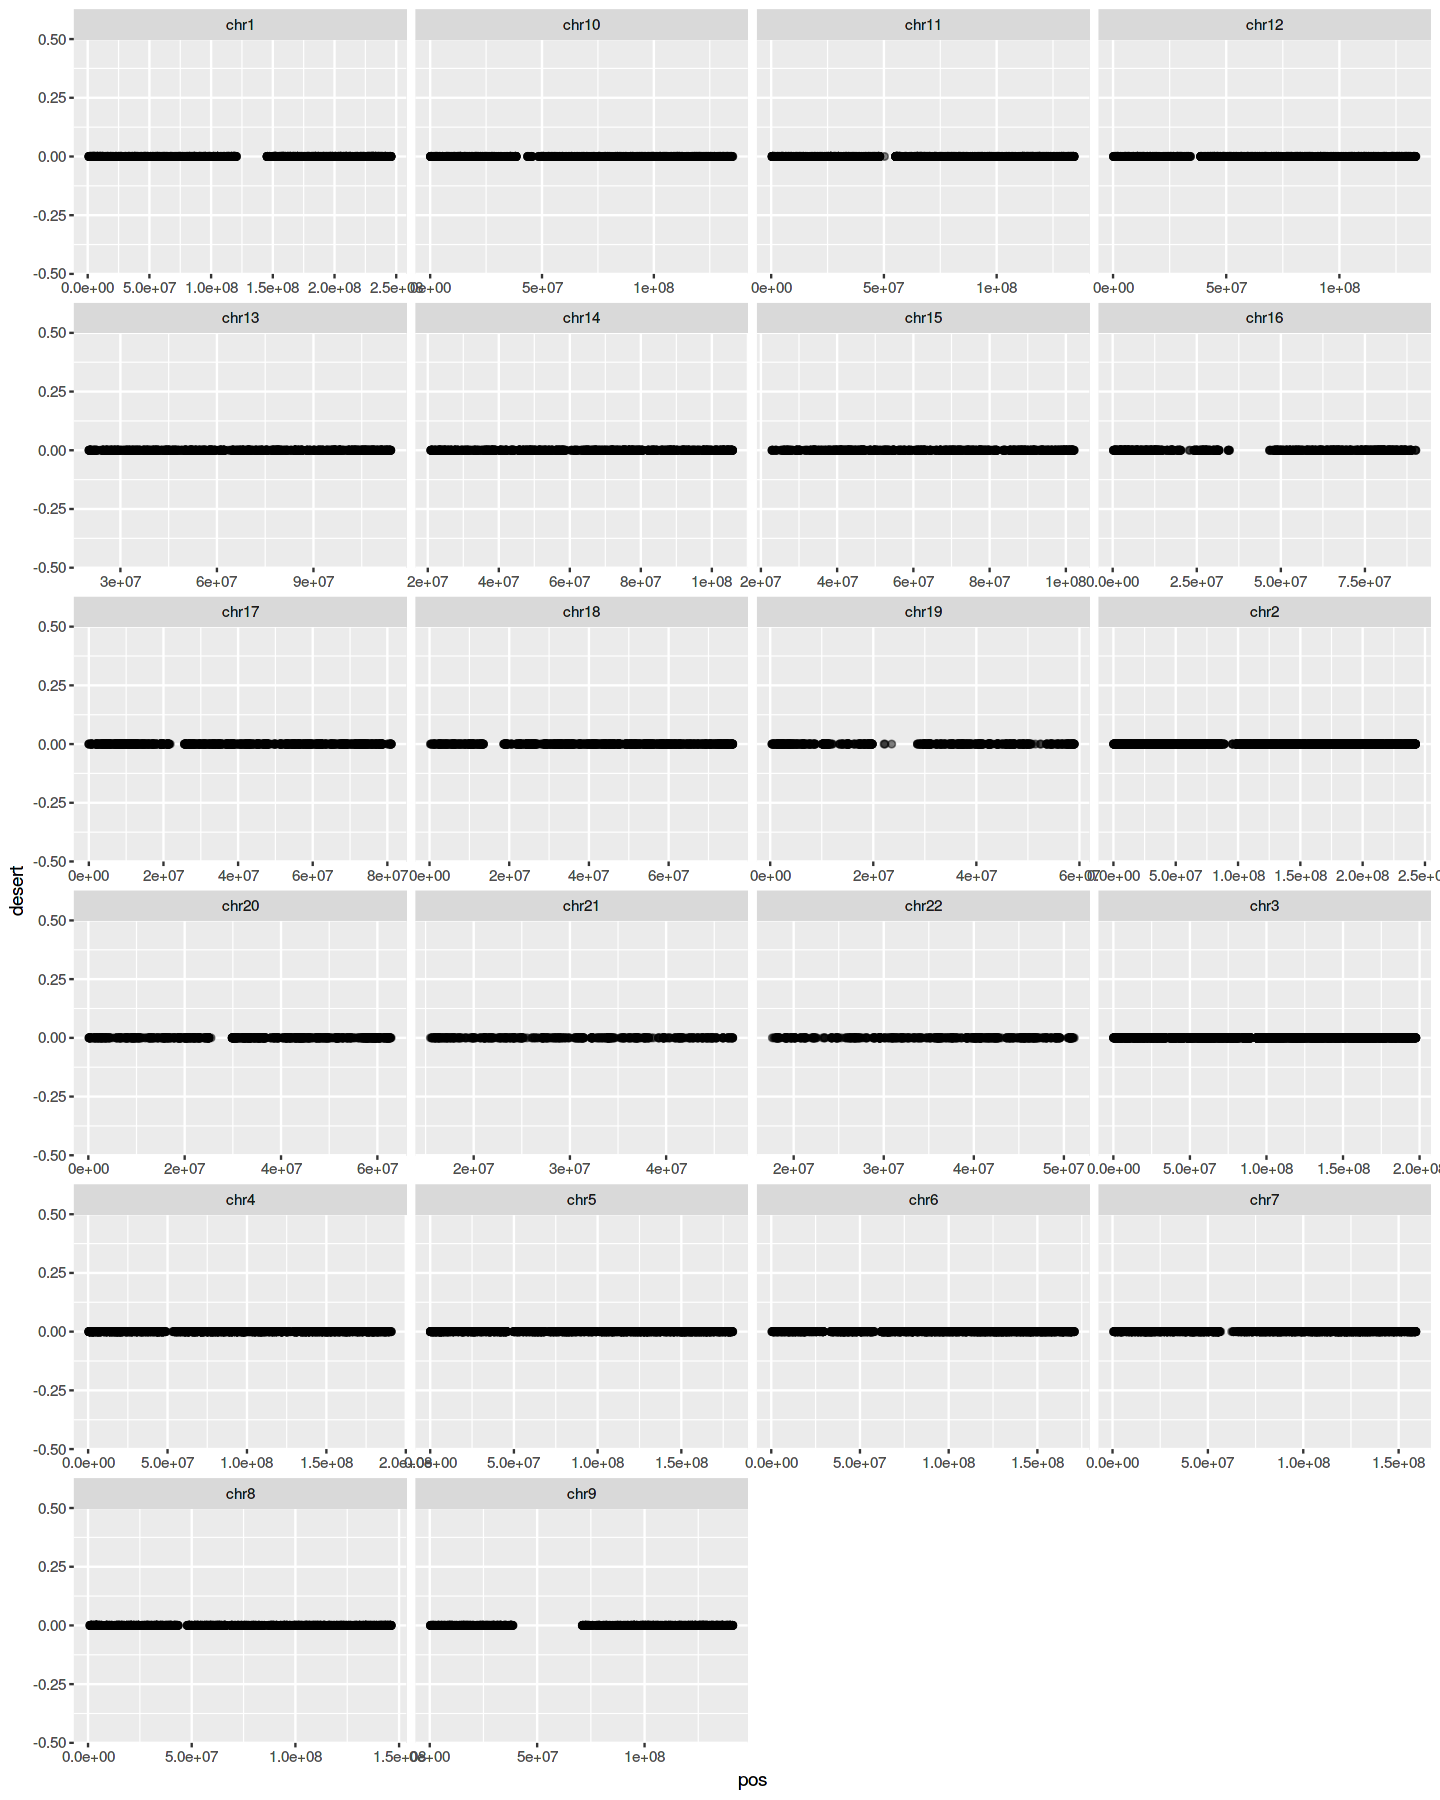

In [12]:
markers %>% mutate(desert=ifelse(freq < 0.001, 0, NA)) %>%
ggplot(aes(pos, desert)) + geom_point(alpha=1/2) + facet_wrap(~ chrom, scales="free_x", ncol=4)

In [30]:
FREQ_CUTOFF <- 0.01

In [40]:
desert_runs <- Rle(as.integer(markers$freq > 0.13))

In [41]:
desert_runs

integer-Rle of length 63073 with 2294 runs
  Lengths:     1     2     3     1     1 ...     4     1     4     3 46645
  Values :     1     0     1     0     1 ...     0     1     0     1     0

In [47]:
Rle(filter(markers, chrom == "chr22")$freq == 0)

logical-Rle of length 791 with 2 runs
  Lengths:   120   671
  Values : FALSE  TRUE